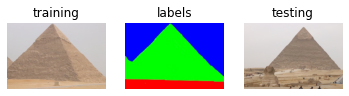

In [18]:
import cv2; #import OpenCV – computer vision functions
import numpy as np; #handle arrays/matrices
import matplotlib.pyplot as plt; #for plotting graphs and showing images
import random;
import math;
from IPython.display import Markdown
no_classes=3;#r,g,b -> labels
no_inputs=3;#r,g,b as input
#====================================================================
orgimg=cv2.imread('pyramid2.jpeg')#training image
img=cv2.cvtColor(orgimg,cv2.COLOR_BGR2RGB);
orgimg_label=cv2.imread('pyramid2_label.jpeg')#training labels
img_label=cv2.cvtColor(orgimg_label,cv2.COLOR_BGR2RGB);
org_test_img=cv2.imread('pyramid1.jpeg')#test image
img_test=cv2.cvtColor(org_test_img,cv2.COLOR_BGR2RGB);
#show the images
plt.subplot(131);plt.imshow(img);plt.title('training');plt.axis('off')
plt.subplot(132);plt.imshow(img_label);plt.title('labels');plt.axis('off');
plt.subplot(133);plt.imshow(img_test);plt.title('testing');plt.axis('off');
plt.show()

In [26]:
#load training data
width=img.shape[1];height=img.shape[0];
No_training_samples=3000;
training_samples_per_class=int(No_training_samples/no_classes);
No_training_samples=training_samples_per_class*no_classes;
training_data=np.zeros([No_training_samples,3]);
training_label=np.zeros(No_training_samples);
no_samples_in_each_class=np.zeros(3);
#ensure equal no of samples of each class is used for the training
j=0;
for a in range (no_classes):
    for i in range(training_samples_per_class):
        rx=int(random.random()*width);
        ry=int(random.random()*height);
        while (img_label[ry,rx,a]<200):
            rx=int(random.random()*width);
            ry=int(random.random()*height);
        training_data[j]=img[ry,rx];
        training_label[j]=a;no_samples_in_each_class[a]+=1;
        j+=1;

In [27]:
#Quantise the data
def quantise(datapoint,mean,stdev):#quantise each data point
    result= ((datapoint-mean)/(3*stdev));
    return result;
def quantise_array(datapoint,mean,stdev,no_bins):#quantise an array
    result=np.zeros(len(datapoint));
    for i in range(len(datapoint)):
        result[i]=int(quantise(datapoint[i],mean[i],stdev[i])*no_bins)+int(no_bins/2);
        if (result[i] >= no_bins):result[i]=no_bins-1;#make sure that it's value is not out of bound
        if (result[i] <0):result[i]=0;
    return result;
def get_means_stdevs_from_array(data):#find the mean and stdev from an array
    mean=np.zeros(data.shape[1]);
    stdev=np.zeros(data.shape[1]);
    for i in range(len(data)):
        mean+=data[i];
    mean/=data.shape[0];
    for i in range(len(data)):
        stdev+=((data[i]-mean)*(data[i]-mean));
    stdev/=data.shape[0];
    stdev=np.sqrt(stdev);#sqrt of an array
    return mean,stdev;

In [28]:
#quantise an image
def quantise_Image(data,no_bins):
    mean=np.zeros(data.shape[1]);
    stdev=np.zeros(data.shape[1]);
    quantised_data=data.copy();
    mean,stdev=get_means_stdevs_from_array(data);
    for i in range(len(data)):
        quantised_data[i]=quantise_array(data[i],mean,stdev,no_bins);
    return mean,stdev,quantised_data;

In [29]:
#Naive Bayesian
#training -> Note: R,G,B are the 3 children nodes and the parent node is the class/output
#we need to quantised the data into number of bins as the input with 0 to 255 will lead to a massive BN
no_bins=8;#quantised in the 8 bins (i.e 0 to 8 )
means,stdevs,quantised_data=quantise_Image(training_data,no_bins);
prior=no_samples_in_each_class/No_training_samples;#prior probabilities
#The likelihoods (we have to find out the likelihood of each R,G,B given the classes)
#P(Red[]|Class[])=P(Red[],Class[])/P(Class[])
Red=np.zeros([no_bins,no_classes]);#counting Red[i] & Class[j]
Green=np.zeros([no_bins,no_classes]);#counting Green[i] & Class[j]
Blue=np.zeros([no_bins,no_classes]);#counting Blue[i] & Class[j]
for i in range(len(quantised_data)):
    Red[int(quantised_data[i][0])][int(training_label[i])]+=1;
    Green[int(quantised_data[i][1])][int(training_label[i])]+=1;
    Blue[int(quantised_data[i][1])][int(training_label[i])]+=1;
#The likelihoods
Red/=len(training_label);
Green/=len(training_label);
Blue/=len(training_label);
P_Red=Red/prior;#P(Red[]|Class[])
P_Green=Green/prior;#P(Green[]|Class[])
P_Blue=Blue/prior;#P(Blue[]|Class[])

In [30]:
#Inferencing
#The Naive Bayesian - Posterior Probability
#P(Class[]|Red[])=alpha*P'(Class[])xP(Red[]|Class[])*P(Green[]|Class[])*P(Blue[]|Class[])
def PosteriorProb(no_classes,prior,P_Red,P_Green,P_Blue,curState):
    result=prior*P_Red[int(curState[0])]*P_Green[int(curState[1])]*P_Blue[int(curState[2])];
    alpha=0;#alpha is the normalisation constant
    for i in range(no_classes):
        alpha+=result[i];
    result=result/alpha;
    return result;
#Segment the image with the Bayesian Networks
def BNSegmentation(means,stdevs,no_bins):
    resultimg=img_test.copy();
    for y in range(height):
        for x in range(width):
            quantised=quantise_array(img_test[y,x],means,stdevs,no_bins);
            posterior=PosteriorProb(no_classes,prior,P_Red,P_Green,P_Blue,quantised);
            #find the one with the highest posterior probability
            whichclass=0;highestPosterior=0;
            for i in range(no_classes):
                if (posterior[i]>highestPosterior):
                    highestPosterior=posterior[i];
                    whichclass=i;
            if (whichclass==0):
                resultimg[y,x,0]=255;resultimg[y,x,1]=0;resultimg[y,x,2]=0;
            elif (whichclass==1):
                resultimg[y,x,1]=255;resultimg[y,x,0]=0;resultimg[y,x,2]=0;
            else: resultimg[y,x,2]=255;resultimg[y,x,1]=0;resultimg[y,x,0]=0;
    return resultimg;

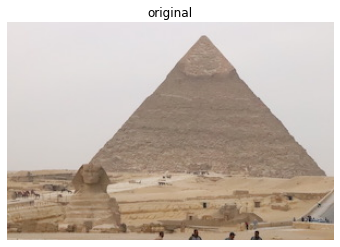

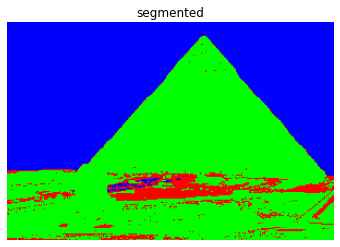

In [31]:
resultimg=BNSegmentation(means,stdevs,no_bins);#segment the image with the Navie Bayesian
#show the results of image segmentation
plt.imshow(img_test);plt.title('original');plt.axis('off');plt.show();
plt.imshow(resultimg);plt.title('segmented');plt.axis('off');plt.show()    